In [3]:
import lhapdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt


# Global Constants
M1_test=np.sqrt(0.8)
Kp2A=0.57
Pp2A=0.12

ee=1
eU=2/3
eUbar=-2/3
eD=-1/3
eDbar=1/3
eS=-1/3
eSbar=1/3

AlphaU_test=1.0
BetaU_test=6.6
AlphaD_test=1.9
BetaD_test=10
AlphaS_test=0
BetaS_test=0

NU_test=0.18
NUbar_test=-0.01
ND_test=-0.52
NDbar_test=-0.06
NS_test=0
NSbar_test=0


Datafile='Data/HERMES_p_2009.csv'
PDFdataset = lhapdf.mkPDF("JAM19PDF_proton_nlo")
#PDFdataset = lhapdf.mkPDF("CT10nnlo")
FF_pion_dataset=["JAM19FF_pion_nlo"]

In [4]:
def dataslice(filename,Had,Var):
    tempdf=pd.read_csv(filename)
    temp_slice=tempdf[(tempdf["hadron"]==Had)&(tempdf["1D_dependence"]==Var)]
    tempQ2=np.array(temp_slice["Q2"])
    tempX=np.array(temp_slice["x"])
    tempZ=np.array(temp_slice["z"])
    tempPHT=np.array(temp_slice["phT"])
    tempSiv=np.array(temp_slice["Siv"])
    temperrSiv=np.array(temp_slice["tot_err"])
    return tempQ2,tempX,tempZ,tempPHT,tempSiv,temperrSiv

def ks2Avg(m1,kperp2Avg):
    test_ks2Avg=((m1**2)*kperp2Avg)/((m1**2)+kperp2Avg)
    return test_ks2Avg

def A0(z,pht,m1,kperp2Avg,pperp2Avg,eCharg):
    tempA0part1=(((z**2)*kperp2Avg+pperp2Avg)*((ks2Avg(m1,kperp2Avg))**2))/((((z**2)*(ks2Avg(m1,kperp2Avg))+pperp2Avg)**2)*kperp2Avg)
    tempA0part21=(pht**2)*(z**2)*(ks2Avg(m1,kperp2Avg) - kperp2Avg)
    tempA0part22=((z**2)*(ks2Avg(m1,kperp2Avg))+pperp2Avg)*((z**2)*kperp2Avg+pperp2Avg)
    tempA0part2=np.exp(-tempA0part21/tempA0part22)
    tempA0part3=(np.sqrt(2*eCharg))*z*pht/m1
    tempA0=tempA0part1*tempA0part2*tempA0part3
    return tempA0


def NNu(x,Nu,alphau,betau):
    tempNNu = Nu*(x**alphau)*((1-x)**(betau))*((alphau+betau)**(alphau+betau))/((alphau**alphau)*(betau**betau))
    return tempNNu

def NNubar(x,Nubar,alphaubar=0,betaubar=0):
    #tempNNubar = Nubar*(x**alphaubar)*((1-x)**(betaubar))*((alphaubar+betaubar)**(alphaubar+betaubar))/((alphaubar**alphaubar)*(betaubar**betaubar))
    tempNNubar = Nubar
    return tempNNubar

def NNd(x,Nd,alphad,betad):
    tempNNd = Nd*(x**alphad)*((1-x)**(betad))*((alphad+betad)**(alphad+betad))/((alphad**alphad)*(betad**betad))
    return tempNNd

def NNdbar(x,Ndbar,alphadbar=0,betadbar=0):
    #tempNNdbar = Ndbar*(x**alphadbar)*((1-x)**(betadbar))*((alphadbar+betadbar)**(alphadbar+betadbar))/((alphadbar**alphadbar)*(betadbar**betadbar))
    tempNNdbar = Ndbar
    return tempNNdbar

def NNs(x,Ns,alphas,betas):
    #tempNNu = Ns*(x**alphas)*((1-x)**(betas))*((alphas+betas)**(alphas+betas))/((alphas**alphas)*(betas**betas))
    tempNNs = 0
    return tempNNs

def NNsbar(x,Nsbar,alphasbar,betasbar):
    #tempNNsbar = Nsbar*(x**alphasbar)*((1-x)**(betasbar))*((alphasbar+betasbar)**(alphasbar+betasbar))/((alphasbar**alphasbar)*(betasbar**betasbar))
    tempNNsbar = 0
    return tempNNsbar


def xFxQ2(dataset,flavor,x,QQ):
    temp_parton_dist_x=(dataset.xfxQ2(flavor, x, QQ))
    return temp_parton_dist_x

def zFzQ(dataset,flavor,zz,QQ):
    # Here "0" represents the central values from the girds
    temp_zD1=lhapdf.mkPDF(dataset[0], 0)
    zD1_vec=(temp_zD1.xfxQ2(flavor,zz,QQ))
    return zD1_vec

In [25]:
### Definitions for hadron = Pi_plus ####

def ASivPiPFitting(KV,m1,Nu,alphau,betau,Ndbar):
    QQ,x,z,pht=KV
    kperp2Avg=Kp2A
    pperpAvg=Pp2A
    eCharg=ee
    eu=eU
    edbar=eDbar
    array_size=len(x)
    tempASivPiP_val=[]
    for i in range(0,array_size):
        Ucontribution1 = NNu(x[i],Nu,alphau,betau)*(eu**2)*xFxQ2(PDFdataset,2,x[i],QQ[i])*zFzQ(FF_pion_dataset,2,z[i],QQ[i])
        dbarcontribution1 = NNdbar(x[i],Ndbar)*(edbar**2)*xFxQ2(PDFdataset,-1,x[i],QQ[i])*zFzQ(FF_pion_dataset,-1,z[i],QQ[i])
        Ucontribution2 = (eu**2)*xFxQ2(PDFdataset,2,x[i],QQ[i])*zFzQ(FF_pion_dataset,2,z[i],QQ[i])
        dbarcontribution2 = (edbar**2)*xFxQ2(PDFdataset,-1,x[i],QQ[i])*zFzQ(FF_pion_dataset,-1,z[i],QQ[i])
        tempNumerator = Ucontribution1 + dbarcontribution1
        tempDenominator = Ucontribution2 + dbarcontribution2
        tempASivPiP = A0(z[i],pht[i],m1,kperp2Avg,pperpAvg,eCharg)*tempNumerator/tempDenominator
        tempASivPiP_val.append(tempASivPiP)
    return tempASivPiP_val

def Chi2PiP(datfile,hadron,dependence,m1,Nu,alphau,betau,Ndbar):
    data_points=len(dataslice(datfile,hadron,dependence)[0])
    temp_kinematics=np.array(dataslice(datfile,hadron,dependence))
    tempQ=temp_kinematics[0]
    tempX=temp_kinematics[1]
    tempZ=temp_kinematics[2]
    tempphT=temp_kinematics[3]
    temp_exp=temp_kinematics[4]
    temp_sigma=temp_kinematics[5]
    temp_theory=ASivPiPFitting((tempQ,tempX,tempZ,tempphT),m1,Nu,alphau,betau,Ndbar)
    temp_Chi2_val=np.sum(((temp_theory-temp_exp)/temp_sigma)**2)
    return temp_Chi2_val

In [17]:
### Here we concatenate data corresponding to a given hadron in the SIDIS process

def Kin_hadron(datfile,hadron):
    ##### Q2 ################
    tempQ2_x=np.array(dataslice(datfile,hadron,"x")[0])
    tempQ2_z=np.array(dataslice(datfile,hadron,"z")[0])
    tempQ2_phT=np.array(dataslice(datfile,hadron,"phT")[0])
    tempQ2=np.concatenate((tempQ2_x,tempQ2_z,tempQ2_phT))
    ##### X ################
    tempX_x=np.array(dataslice(datfile,hadron,"x")[1])
    tempX_z=np.array(dataslice(datfile,hadron,"z")[1])
    tempX_phT=np.array(dataslice(datfile,hadron,"phT")[1])
    tempX=np.concatenate((tempX_x,tempX_z,tempX_phT))
    ##### Z ################
    tempZ_x=np.array(dataslice(datfile,hadron,"x")[2])
    tempZ_z=np.array(dataslice(datfile,hadron,"z")[2])
    tempZ_phT=np.array(dataslice(datfile,hadron,"phT")[2])
    tempZ=np.concatenate((tempZ_x,tempZ_z,tempZ_phT))
    ##### phT ################
    tempphT_x=np.array(dataslice(datfile,hadron,"x")[3])
    tempphT_z=np.array(dataslice(datfile,hadron,"z")[3])
    tempphT_phT=np.array(dataslice(datfile,hadron,"phT")[3])
    tempphT=np.concatenate((tempphT_x,tempphT_z,tempphT_phT))
    return tempQ2,tempX,tempZ,tempphT

  
def ASivPiP_data(datfile,hadron):
    ##### Asy ################
    tempAsy_x=np.array(dataslice(datfile,hadron,"x")[4])
    tempAsy_z=np.array(dataslice(datfile,hadron,"z")[4])
    tempAsy_phT=np.array(dataslice(datfile,hadron,"phT")[4])
    tempAsy=np.concatenate((tempAsy_x,tempAsy_z,tempAsy_phT))
    ##### err ################
    tempAsyErr_x=np.array(dataslice(datfile,hadron,"x")[5])
    tempAsyErr_z=np.array(dataslice(datfile,hadron,"z")[5])
    tempAsyErr_phT=np.array(dataslice(datfile,hadron,"phT")[5])
    tempAsyErr=np.concatenate((tempAsyErr_x,tempAsyErr_z,tempAsyErr_phT))
    return tempAsy,tempAsyErr


In [10]:
### Fitting to the data for single hadron (all x,z,phT dependencies are considered)    
kin=Kin_hadron(Datafile,"pi+")
test_func=ASivPiP_data(Datafile,"pi+")[0]
test_func_err=ASivPiP_data(Datafile,"pi+")[1]
#p0=1,1,1,1,1
p0=M1_test,NU_test,AlphaU_test,BetaU_test,NDbar_test
result, result_cov=opt.curve_fit(ASivPiPFitting,kin,test_func,p0,sigma=test_func_err,method='lm')
print(result)

[4.91162004e+03 5.04552221e+02 8.04656412e-01 2.61855427e+00
 4.65542195e+02]


In [39]:
dep="x"

In [40]:
Chi2PiP(Datafile,"pi+",dep,result[0],result[1],result[2],result[3],result[4]) 

8.848673248355267

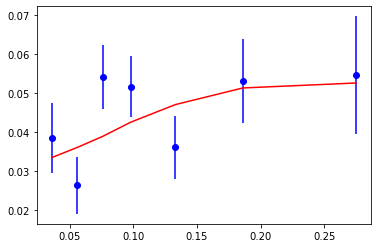

In [41]:
def PlotSiversPiP(datfile,hadron,dependence,m1,Nu,alphau,betau,Ndbar):
    kperp2Avg=Kp2A
    pperpAvg=Pp2A
    eCharg=ee
    eu=eU
    edbar=eDbar
    data_points=len(dataslice(datfile,hadron,dependence)[0])
    temp_kinematics=np.array(dataslice(datfile,hadron,dependence))
    if(dependence=="x"):
        dep_index=1
    elif(dependence=="z"):
        dep_index=2
    elif(dependence=="phT"):
        dep_index=3
    tempQ=temp_kinematics[0]
    tempX=temp_kinematics[1]
    tempZ=temp_kinematics[2]
    tempphT=temp_kinematics[3]
    temp_exp=temp_kinematics[4]
    temp_sigma=temp_kinematics[5]
    temp_theory=ASivPiPFitting((tempQ,tempX,tempZ,tempphT),m1,Nu,alphau,betau,Ndbar)
    plt.plot(temp_kinematics[dep_index],temp_theory,'red')
    plt.errorbar(temp_kinematics[dep_index],temp_kinematics[4],temp_kinematics[5],fmt='o',color='blue')

PlotSiversPiP(Datafile,"pi+",dep,result[0],result[1],result[2],result[3],result[4])
#plt.ylim(0.0,0.1)
#plt.xlim(0.0,0.35)

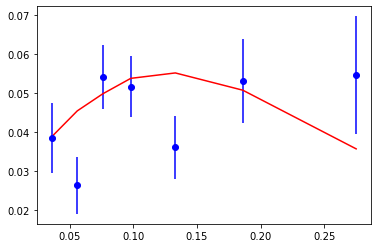

In [42]:
### This shows the solution by Anzelmino's fit results
PlotSiversPiP(Datafile,"pi+",dep,M1_test,NU_test,AlphaU_test,BetaU_test,NDbar_test)